# Analiza Regulacji Emocjonalnej - WESAD

## Cel badania

Chcemy zmierzyć regulację emocjonalną u osób badanych w dwóch warunkach:
- **baseline** – stan spoczynku
- **emotion / stres** – np. stres matematyczny lub zadanie emocjonalne

Używamy sygnałów fizjologicznych:
- **EDA** (przewodnictwo skóry)
- **BVP** (puls)
- **TEMP** (temperatura skóry)

Celem jest określenie:
- Jak szybko reaguje ciało (**latencja**)
- Jak mocna jest reakcja (**amplituda piku**)
- Jak długo trwa reakcja (**duration**)
- Jak gwałtowny jest wzrost i spadek (**slope i decay**)
- Łącznej aktywacji (**AUC** - Area Under Curve)

## Pipeline analizy sygnału

1. **Wczytanie danych** – surowe sygnały z WESAD dla każdej osoby i każdej próbki w czasie
2. **Odszumianie / filtracja** – EDA: low-pass ~1 Hz, BVP: low-pass ~4 Hz, TEMP: opcjonalne wygładzenie
3. **Baseline** – okres spoczynkowy przed bodźcem (np. pierwsze 30 s), obliczamy średnią i SD baseline. Korekcja sygnału: `x_corrected = x - baseline_mean`. Normalizacja opcjonalna: `x_zscore = x_corrected / baseline_std`
4. **Segmentacja sygnału** – wyodrębnienie okresu po bodźcu: `t_stimulus_onset → t_stimulus_end`
5. **Wyciąganie parametrów reakcji** – Latencja, Amplituda piku, Czas trwania piku (duration), Slope, Decay, AUC
6. **Agregacja danych** – dla każdej osoby i sygnału jeden wiersz z parametrami. Porównywanie warunków emotion vs baseline statystycznie (t-test, ANOVA, regresja)

## Interpretacja wyników

Różne możliwe scenariusze reakcji:
- **Szybki pik, wysoka amplituda, krótki decay** → nagła, silna reakcja stresowa z szybką regulacją
- **Szybki pik, wysoka amplituda, długie wygasanie** → silna reakcja trudna do wyregulowania
- **Wolny pik, niska amplituda** → osłabiona reakcja emocjonalna lub wysoka odporność
- **Brak piku lub płaski sygnał** → minimalna reakcja, możliwe tłumienie emocji lub brak percepcji bodźca


## KROK 1: Import bibliotek i konfiguracja


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# Filtracja sygnałów
from scipy.signal import butter, filtfilt, find_peaks
from scipy import integrate

# Sprawdź czy trapezoid jest dostępne (nowsza wersja scipy)
try:
    from scipy.integrate import trapezoid
    HAS_TRAPEZOID = True
except ImportError:
    # Fallback do trapz (starsza wersja)
    from scipy.integrate import trapz as trapezoid
    HAS_TRAPEZOID = False

# Statystyka
from scipy.stats import ttest_rel, f_oneway

# Konfiguracja
RAW_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD")
SELECTED_SUBJECTS = ["S2", "S3", "S4"]

# Parametry sygnałów
EDA_SAMPLING_HZ = 4.0   # EDA: 4 Hz
BVP_SAMPLING_HZ = 64.0  # BVP: 64 Hz
TEMP_SAMPLING_HZ = 4.0  # TEMP: 4 Hz

# Częstotliwość próbkowania label (etykiety faz są w tej częstotliwości)
# W WESAD label jest prawdopodobnie w częstotliwości BVP (64 Hz) lub wyższej
LABEL_SAMPLING_HZ = 64.0  # Zakładamy 64 Hz dla label

# Parametry filtracji
EDA_LOWPASS_HZ = 1.0    # Low-pass dla EDA: ~1 Hz
BVP_LOWPASS_HZ = 4.0    # Low-pass dla BVP: ~4 Hz

# Parametry baseline
BASELINE_DURATION_S = 30  # Pierwsze 30 sekund jako baseline

# Parametry wykrywania reakcji
SIGNIFICANT_THRESHOLD = 2.0  # 2 SD powyżej baseline = znaczący wzrost
PEAK_THRESHOLD_PERCENT = 0.5  # 50% amplitudy = próg dla duration

print("✅ Biblioteki zaimportowane")
print(f"✅ Wybrane osoby: {SELECTED_SUBJECTS}")


✅ Biblioteki zaimportowane
✅ Wybrane osoby: ['S2', 'S3', 'S4']


## KROK 2: Funkcje pomocnicze - filtracja i preprocessing


In [2]:
def butter_lowpass(cutoff, fs, order=4):
    """Tworzy filtr Butterworth low-pass"""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(signal, cutoff_hz, sampling_hz, order=4):
    """Aplikuje filtr low-pass do sygnału"""
    if len(signal) < order * 3:
        return signal  # Za krótki sygnał
    
    try:
        b, a = butter_lowpass(cutoff_hz, sampling_hz, order)
        filtered = filtfilt(b, a, signal)
        return filtered
    except:
        return signal  # Fallback jeśli filtracja się nie powiedzie

def smooth_signal(signal, window_size=5):
    """Wygładza sygnał używając moving average (dla TEMP)"""
    if len(signal) < window_size:
        return signal
    
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(signal, window, mode='same')
    return smoothed

def compute_baseline(signal, baseline_duration_s, sampling_hz):
    """
    Oblicza baseline (średnia i SD) z pierwszych N sekund sygnału.
    
    Returns:
        baseline_mean: średnia wartość baseline (skalar float)
        baseline_std: odchylenie standardowe baseline (skalar float)
        baseline_indices: indeksy próbek baseline
    """
    baseline_samples = int(baseline_duration_s * sampling_hz)
    baseline_samples = min(baseline_samples, len(signal))
    
    if baseline_samples == 0:
        return np.nan, np.nan, np.array([])
    
    baseline_segment = np.asarray(signal[:baseline_samples])
    baseline_mean = float(np.mean(baseline_segment))
    baseline_std = float(np.std(baseline_segment))
    baseline_indices = np.arange(baseline_samples)
    
    return baseline_mean, baseline_std, baseline_indices

def correct_baseline(signal, baseline_mean, normalize=False, baseline_std=None):
    """
    Korekta sygnału względem baseline.
    
    Parameters:
        signal: sygnał do korekty
        baseline_mean: średnia baseline
        normalize: czy normalizować przez SD (z-score)
        baseline_std: odchylenie standardowe baseline (wymagane jeśli normalize=True)
    
    Returns:
        corrected_signal: x_corrected = x - baseline_mean
        Jeśli normalize=True: x_zscore = x_corrected / baseline_std
    """
    corrected = signal - baseline_mean
    
    if normalize and baseline_std is not None and baseline_std > 0:
        corrected = corrected / baseline_std
    
    return corrected

print("✅ Funkcje filtracji i preprocessing zdefiniowane")


✅ Funkcje filtracji i preprocessing zdefiniowane


## KROK 3: Funkcje do wyciągania parametrów reakcji


In [3]:
def extract_reaction_parameters(signal, baseline_mean, baseline_std, sampling_hz, 
                                stimulus_start_idx=0, stimulus_end_idx=None):
    """
    Wyciąga parametry reakcji z sygnału po bodźcu.
    
    Parameters:
        signal: sygnał (już skorygowany względem baseline)
        baseline_mean: średnia baseline (do obliczenia amplitudy)
        baseline_std: SD baseline (do wykrywania znaczących zmian)
        sampling_hz: częstotliwość próbkowania
        stimulus_start_idx: indeks początku bodźca (domyślnie 0 = koniec baseline)
        stimulus_end_idx: indeks końca bodźca (None = do końca sygnału)
    
    Returns:
        dict z parametrami:
        - latency_s: czas do pierwszego znaczącego wzrostu (s)
        - peak_amplitude: maksymalny wzrost względem baseline
        - peak_index: indeks piku
        - duration_s: czas trwania piku (gdy sygnał > 50% amplitudy) (s)
        - slope: tempo wzrostu od początku reakcji do piku
        - decay: tempo powrotu do baseline
        - auc: powierzchnia pod krzywą reakcji (Area Under Curve)
    """
    if stimulus_end_idx is None:
        stimulus_end_idx = len(signal)
    
    stimulus_segment = signal[stimulus_start_idx:stimulus_end_idx]
    
    if len(stimulus_segment) == 0:
        return {
            'latency_s': np.nan,
            'peak_amplitude': np.nan,
            'peak_index': None,
            'duration_s': np.nan,
            'slope': np.nan,
            'decay': np.nan,
            'auc': np.nan
        }
    
    # Próg znaczącego wzrostu (2 SD powyżej baseline)
    baseline_std_scalar = float(np.asarray(baseline_std).item()) if not np.isnan(baseline_std) and baseline_std > 0 else 0.0
    significant_threshold = SIGNIFICANT_THRESHOLD * baseline_std_scalar
    
    # 1. LATENCJA: czas do pierwszego znaczącego wzrostu
    latency_idx = None
    for i in range(len(stimulus_segment)):
        val = float(np.asarray(stimulus_segment[i]).item())
        if val >= significant_threshold:
            latency_idx = i
            break
    
    latency_s = float(latency_idx / sampling_hz) if latency_idx is not None else np.nan
    
    # 2. AMPLITUDA PIKU: maksymalny wzrost względem baseline
    peak_idx_local = np.argmax(stimulus_segment)
    peak_idx = int(stimulus_start_idx + peak_idx_local)
    peak_amplitude = float(np.asarray(stimulus_segment[peak_idx_local]).item())
    
    # 3. DURATION: czas gdy sygnał przekracza 50% amplitudy
    peak_threshold = PEAK_THRESHOLD_PERCENT * peak_amplitude
    
    # Znajdź pierwszy punkt powyżej progu (przed peakiem)
    duration_start = None
    for i in range(peak_idx_local, -1, -1):
        val = float(np.asarray(stimulus_segment[i]).item())
        if val < peak_threshold:
            duration_start = i + 1
            break
    if duration_start is None:
        duration_start = 0
    
    # Znajdź ostatni punkt powyżej progu (po peaku)
    duration_end = None
    for i in range(peak_idx_local, len(stimulus_segment)):
        val = float(np.asarray(stimulus_segment[i]).item())
        if val < peak_threshold:
            duration_end = i
            break
    if duration_end is None:
        duration_end = len(stimulus_segment)
    
    duration_s = float((duration_end - duration_start) / sampling_hz) if duration_start is not None else np.nan
    
    # 4. SLOPE: tempo wzrostu od początku reakcji do piku
    if latency_idx is not None and peak_idx_local > latency_idx:
        rise_time = (peak_idx_local - latency_idx) / sampling_hz
        slope = float(peak_amplitude / rise_time) if rise_time > 0 else np.nan
    else:
        slope = np.nan
    
    # 5. DECAY: tempo powrotu do baseline
    # Szukamy gdzie sygnał wraca do baseline (tolerancja: 10% baseline_std)
    baseline_std_scalar = float(np.asarray(baseline_std).item()) if not np.isnan(baseline_std) else 0.0
    decay_threshold = 0.1 * baseline_std_scalar if baseline_std_scalar > 0 else 0
    decay_end_idx = None
    
    for i in range(peak_idx_local, len(stimulus_segment)):
        val = float(np.asarray(stimulus_segment[i]).item())
        if abs(val) <= decay_threshold:
            decay_end_idx = i
            break
    
    if decay_end_idx is not None and decay_end_idx > peak_idx_local:
        decay_time = (decay_end_idx - peak_idx_local) / sampling_hz
        decay = float(peak_amplitude / decay_time) if decay_time > 0 else np.nan
    else:
        decay = np.nan
    
    # 6. AUC: powierzchnia pod krzywą reakcji
    # Obliczamy AUC dla całego segmentu bodźca (względem baseline = 0)
    # Używamy całkowania numerycznego (metoda trapezów)
    try:
        # Upewnij się, że stimulus_segment jest 1D numpy array
        stimulus_segment_1d = np.asarray(stimulus_segment, dtype=float)
        
        # Spłaszcz do 1D jeśli potrzeba
        if stimulus_segment_1d.ndim > 1:
            stimulus_segment_1d = stimulus_segment_1d.flatten()
        
        # Upewnij się że jest 1D
        if stimulus_segment_1d.ndim != 1:
            auc = np.nan
        elif len(stimulus_segment_1d) == 0:
            auc = np.nan
        else:
            # Tylko dodatnie wartości (względem baseline = 0)
            positive_values = np.maximum(stimulus_segment_1d, 0)
            
            # Sprawdź kształt
            if positive_values.ndim != 1:
                positive_values = positive_values.flatten()
            
            n_samples = len(positive_values)
            
            # Sprawdź czy mamy wystarczająco próbek
            if n_samples > 1:
                # Oblicz AUC ręcznie używając metody trapezów (prostsze i bardziej niezawodne)
                dx = 1.0 / sampling_hz  # Krok czasowy w sekundach
                # Suma trapezów: (y[i] + y[i+1]) / 2 * dx
                auc = float(np.sum((positive_values[:-1] + positive_values[1:]) / 2.0) * dx)
            elif n_samples == 1:
                auc = float(positive_values[0] * (1.0 / sampling_hz))
            else:
                auc = np.nan
    except Exception as e:
        # Jeśli coś pójdzie nie tak, zwróć NaN
        auc = np.nan
    
    return {
        'latency_s': float(latency_s) if not np.isnan(latency_s) else np.nan,
        'peak_amplitude': float(peak_amplitude),
        'peak_index': peak_idx,
        'duration_s': float(duration_s) if not np.isnan(duration_s) else np.nan,
        'slope': float(slope) if not np.isnan(slope) else np.nan,
        'decay': float(decay) if not np.isnan(decay) else np.nan,
        'auc': float(auc)
    }

print("✅ Funkcje do wyciągania parametrów reakcji zdefiniowane")


✅ Funkcje do wyciągania parametrów reakcji zdefiniowane


## KROK 4: Wczytywanie danych WESAD


In [4]:
def load_wesad_pickle(subject):
    """Wczytuje dane WESAD z pliku .pkl"""
    pkl_path = RAW_ROOT / subject / f"{subject}.pkl"
    if not pkl_path.exists():
        raise FileNotFoundError(f"Brak pliku {pkl_path}")
    
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    
    return data

def extract_phase_indices(data):
    """Wyciąga indeksy faz z danych WESAD"""
    if 'label' not in data:
        return None
    
    labels = np.array(data['label'])
    
    # Mapowanie etykiet WESAD: 0=baseline, 1=stress, 2=amusement
    baseline_indices = np.where(labels == 0)[0]
    stress_indices = np.where(labels == 1)[0]
    amusement_indices = np.where(labels == 2)[0]
    
    phase_indices = {
        'baseline': baseline_indices,
        'stress': stress_indices,
        'amusement': amusement_indices
    }
    
    return phase_indices

def scale_phase_indices(phase_indices, label_fs, target_fs, target_signal_len):
    """
    Przeskaluj indeksy faz z częstotliwości label do częstotliwości docelowego sygnału.
    
    Parameters:
        phase_indices: dict z indeksami faz (w skali label_fs)
        label_fs: częstotliwość próbkowania label (prawdopodobnie 64 Hz lub wyższa)
        target_fs: częstotliwość próbkowania docelowego sygnału (np. 4 Hz dla EDA)
        target_signal_len: długość docelowego sygnału
    
    Returns:
        scaled_phase_indices: dict z przeskalowanymi indeksami
    """
    if phase_indices is None:
        return None
    
    scaled = {}
    scale_factor = target_fs / label_fs
    
    for phase_name, indices in phase_indices.items():
        if len(indices) > 0:
            # Przeskaluj indeksy
            scaled_indices = (indices * scale_factor).astype(int)
            # Ogranicz do długości sygnału
            scaled_indices = scaled_indices[scaled_indices < target_signal_len]
            scaled[phase_name] = scaled_indices
        else:
            scaled[phase_name] = np.array([], dtype=int)
    
    return scaled

# Wczytaj dane dla wszystkich osób
subjects_data = {}

for subject in SELECTED_SUBJECTS:
    print(f"\n📂 Wczytuję dane dla {subject}...")
    try:
        data = load_wesad_pickle(subject)
        
        # Wyciągnij sygnały z nadgarstka
        wrist_signals = data['signal'].get('wrist', {})
        
        # EDA - obsługa różnych formatów (lista, tablica, itp.)
        eda_data = wrist_signals.get('EDA', [])
        if isinstance(eda_data, (list, tuple)):
            eda_raw = np.array(eda_data)
        elif isinstance(eda_data, np.ndarray):
            eda_raw = eda_data.flatten() if eda_data.ndim > 1 else eda_data
        else:
            eda_raw = np.array([])
        
        if len(eda_raw) == 0:
            print(f"  ⚠️ Brak danych EDA dla {subject}")
            eda_raw = np.array([])
        
        # BVP - obsługa różnych formatów
        bvp_data = wrist_signals.get('BVP', [])
        if isinstance(bvp_data, (list, tuple)):
            bvp_raw = np.array(bvp_data)
        elif isinstance(bvp_data, np.ndarray):
            bvp_raw = bvp_data.flatten() if bvp_data.ndim > 1 else bvp_data
        else:
            bvp_raw = np.array([])
        
        if len(bvp_raw) == 0:
            print(f"  ⚠️ Brak danych BVP dla {subject}")
            bvp_raw = np.array([])
        
        # TEMP - obsługa różnych formatów
        temp_data = wrist_signals.get('TEMP', [])
        if isinstance(temp_data, (list, tuple)):
            temp_raw = np.array(temp_data)
        elif isinstance(temp_data, np.ndarray):
            temp_raw = temp_data.flatten() if temp_data.ndim > 1 else temp_data
        else:
            temp_raw = np.array([])
        
        if len(temp_raw) == 0:
            print(f"  ⚠️ Brak danych TEMP dla {subject}")
            temp_raw = np.array([])
        
        # Phase indices
        phase_indices = extract_phase_indices(data)
        
        subjects_data[subject] = {
            'eda': eda_raw,
            'bvp': bvp_raw,
            'temp': temp_raw,
            'phase_indices': phase_indices
        }
        
        print(f"  ✅ EDA: {len(eda_raw)} próbek")
        print(f"  ✅ BVP: {len(bvp_raw)} próbek")
        print(f"  ✅ TEMP: {len(temp_raw)} próbek")
        
    except Exception as e:
        print(f"  ❌ Błąd podczas wczytywania {subject}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n✅ Wczytano dane dla {len(subjects_data)} osób")



📂 Wczytuję dane dla S2...
  ✅ EDA: 24316 próbek
  ✅ BVP: 389056 próbek
  ✅ TEMP: 24316 próbek

📂 Wczytuję dane dla S3...
  ✅ EDA: 25972 próbek
  ✅ BVP: 415552 próbek
  ✅ TEMP: 25972 próbek

📂 Wczytuję dane dla S4...
  ✅ EDA: 25692 próbek
  ✅ BVP: 411072 próbek
  ✅ TEMP: 25692 próbek

✅ Wczytano dane dla 3 osób


## KROK 5: Preprocessing i analiza dla każdej osoby


In [5]:
# Przechowuj wyniki dla wszystkich osób i sygnałów
all_results = []

print(f"\n{'='*80}")
print(f"ROZPOCZYNAM ANALIZĘ DLA {len(SELECTED_SUBJECTS)} OSÓB")
print(f"{'='*80}")
print(f"Osoby do analizy: {SELECTED_SUBJECTS}")
print(f"Dostępne dane: {list(subjects_data.keys())}")

for subject in SELECTED_SUBJECTS:
    if subject not in subjects_data:
        print(f"\n⚠️ Pomijam {subject} - brak danych w subjects_data")
        continue
    
    print(f"\n{'='*80}")
    print(f"ANALIZA: {subject}")
    print(f"{'='*80}")
    
    data = subjects_data[subject]
    phase_indices = data.get('phase_indices', {})
    
    # Diagnostyka
    print(f"\n📋 DIAGNOSTYKA DANYCH:")
    print(f"   EDA: {len(data.get('eda', []))} próbek")
    print(f"   BVP: {len(data.get('bvp', []))} próbek")
    print(f"   TEMP: {len(data.get('temp', []))} próbek")
    if phase_indices:
        print(f"   Phase indices dostępne: {list(phase_indices.keys())}")
        for phase_name, indices in phase_indices.items():
            print(f"      {phase_name}: {len(indices)} indeksów")
    else:
        print(f"   ⚠️ Brak phase_indices!")
    
    # ========== ANALIZA EDA ==========
    try:
        if len(data['eda']) > 0:
            print(f"\n📊 ANALIZA EDA")
            
            eda_raw = data['eda']
            
            # 1. Filtracja: low-pass ~1 Hz
            eda_filtered = lowpass_filter(eda_raw, EDA_LOWPASS_HZ, EDA_SAMPLING_HZ)
            print(f"   ✅ Filtracja low-pass {EDA_LOWPASS_HZ} Hz")
            
            # 2. Baseline: pierwsze 30 sekund
            baseline_mean, baseline_std, baseline_idx = compute_baseline(
                eda_filtered, BASELINE_DURATION_S, EDA_SAMPLING_HZ
            )
            # Upewnij się, że są skalarami
            baseline_mean = float(baseline_mean) if not np.isnan(baseline_mean) else np.nan
            baseline_std = float(baseline_std) if not np.isnan(baseline_std) else np.nan
            print(f"   ✅ Baseline: mean={baseline_mean:.4f}, std={baseline_std:.4f}")
            
            # 3. Korekcja sygnału
            eda_corrected = correct_baseline(eda_filtered, baseline_mean, normalize=False)
            
            # 4. Segmentacja: okres stress (jeśli dostępny)
            # Przeskaluj indeksy faz do częstotliwości EDA (4 Hz)
            eda_phase_indices = scale_phase_indices(
                phase_indices, LABEL_SAMPLING_HZ, EDA_SAMPLING_HZ, len(eda_corrected)
            )
            
            if eda_phase_indices and len(eda_phase_indices.get('stress', [])) > 0:
                stress_indices = eda_phase_indices['stress']
                if len(stress_indices) > 0:
                    stress_start_idx = int(stress_indices[0])
                    stress_end_idx = int(stress_indices[-1]) + 1
                    
                    # Ogranicz do długości sygnału
                    stress_start_idx = max(0, min(stress_start_idx, len(eda_corrected) - 1))
                    stress_end_idx = max(stress_start_idx + 1, min(stress_end_idx, len(eda_corrected)))
                else:
                    stress_start_idx = None
                    stress_end_idx = None
            else:
                stress_start_idx = None
                stress_end_idx = None
            
            if stress_start_idx is not None and stress_end_idx is not None:
                
                # 5. Wyciąganie parametrów reakcji
                params = extract_reaction_parameters(
                    eda_corrected, baseline_mean, baseline_std, EDA_SAMPLING_HZ,
                    stimulus_start_idx=stress_start_idx,
                    stimulus_end_idx=stress_end_idx
                )
                
                # Zapisz wyniki
                result_row = {
                    'subject': subject,
                    'signal': 'EDA',
                    'condition': 'stress',
                    'latency_s': params['latency_s'],
                    'peak_amplitude': params['peak_amplitude'],
                    'duration_s': params['duration_s'],
                    'slope': params['slope'],
                    'decay': params['decay'],
                    'auc': params['auc']
                }
                all_results.append(result_row)
                
                print(f"   ✅ Parametry reakcji:")
                # Bezpieczne formatowanie - sprawdź czy nie NaN
                latency_str = f"{params['latency_s']:.2f}" if not np.isnan(params['latency_s']) else "N/A"
                amplitude_str = f"{params['peak_amplitude']:.4f}" if not np.isnan(params['peak_amplitude']) else "N/A"
                duration_str = f"{params['duration_s']:.2f}" if not np.isnan(params['duration_s']) else "N/A"
                slope_str = f"{params['slope']:.4f}" if not np.isnan(params['slope']) else "N/A"
                decay_str = f"{params['decay']:.4f}" if not np.isnan(params['decay']) else "N/A"
                auc_str = f"{params['auc']:.4f}" if not np.isnan(params['auc']) else "N/A"
                
                print(f"      • Latencja: {latency_str} s")
                print(f"      • Amplituda piku: {amplitude_str}")
                print(f"      • Duration: {duration_str} s")
                print(f"      • Slope: {slope_str}")
                print(f"      • Decay: {decay_str}")
                print(f"      • AUC: {auc_str}")
            
            # Analiza baseline (dla porównania)
            if eda_phase_indices and len(eda_phase_indices.get('baseline', [])) > 0:
                baseline_indices = eda_phase_indices['baseline']
                if len(baseline_indices) > 0:
                    baseline_start_idx = int(baseline_indices[0])
                    baseline_end_idx = min(baseline_start_idx + int(BASELINE_DURATION_S * EDA_SAMPLING_HZ), 
                                           len(eda_corrected))
                else:
                    baseline_start_idx = None
                    baseline_end_idx = None
            else:
                baseline_start_idx = None
                baseline_end_idx = None
            
            if baseline_start_idx is not None and baseline_end_idx is not None:
                
                # Dla baseline, parametry powinny być bliskie 0
                baseline_params = extract_reaction_parameters(
                    eda_corrected, baseline_mean, baseline_std, EDA_SAMPLING_HZ,
                    stimulus_start_idx=baseline_start_idx,
                    stimulus_end_idx=baseline_end_idx
                )
                
                result_row_baseline = {
                    'subject': subject,
                    'signal': 'EDA',
                    'condition': 'baseline',
                    'latency_s': baseline_params['latency_s'],
                    'peak_amplitude': baseline_params['peak_amplitude'],
                    'duration_s': baseline_params['duration_s'],
                    'slope': baseline_params['slope'],
                    'decay': baseline_params['decay'],
                    'auc': baseline_params['auc']
                }
                all_results.append(result_row_baseline)
    except Exception as e:
        print(f"   ❌ Błąd podczas analizy EDA dla {subject}: {e}")
        import traceback
        traceback.print_exc()
    
    # ========== ANALIZA BVP ==========
    try:
        if len(data['bvp']) > 0:
            print(f"\n📊 ANALIZA BVP")
            
            bvp_raw = data['bvp']
            
            # 1. Filtracja: low-pass ~4 Hz
            bvp_filtered = lowpass_filter(bvp_raw, BVP_LOWPASS_HZ, BVP_SAMPLING_HZ)
        print(f"   ✅ Filtracja low-pass {BVP_LOWPASS_HZ} Hz")
        
        # 2. Baseline
        baseline_mean, baseline_std, baseline_idx = compute_baseline(
            bvp_filtered, BASELINE_DURATION_S, BVP_SAMPLING_HZ
        )
        # Upewnij się, że są skalarami
        baseline_mean = float(baseline_mean) if not np.isnan(baseline_mean) else np.nan
        baseline_std = float(baseline_std) if not np.isnan(baseline_std) else np.nan
        print(f"   ✅ Baseline: mean={baseline_mean:.4f}, std={baseline_std:.4f}")
        
        # 3. Korekcja sygnału
        bvp_corrected = correct_baseline(bvp_filtered, baseline_mean, normalize=False)
        
        # 4-5. Segmentacja i parametry
        # Przeskaluj indeksy faz do częstotliwości BVP (64 Hz)
        bvp_phase_indices = scale_phase_indices(
            phase_indices, LABEL_SAMPLING_HZ, BVP_SAMPLING_HZ, len(bvp_corrected)
        )
        
        if bvp_phase_indices and len(bvp_phase_indices.get('stress', [])) > 0:
            stress_indices = bvp_phase_indices['stress']
            if len(stress_indices) > 0:
                stress_start_idx = int(stress_indices[0])
                stress_end_idx = int(stress_indices[-1]) + 1
                
                # Ogranicz do długości sygnału
                stress_start_idx = max(0, min(stress_start_idx, len(bvp_corrected) - 1))
                stress_end_idx = max(stress_start_idx + 1, min(stress_end_idx, len(bvp_corrected)))
            else:
                stress_start_idx = None
                stress_end_idx = None
        else:
            stress_start_idx = None
            stress_end_idx = None
        
        if stress_start_idx is not None and stress_end_idx is not None:
            
            params = extract_reaction_parameters(
                bvp_corrected, baseline_mean, baseline_std, BVP_SAMPLING_HZ,
                stimulus_start_idx=stress_start_idx,
                stimulus_end_idx=stress_end_idx
            )
            
            result_row = {
                'subject': subject,
                'signal': 'BVP',
                'condition': 'stress',
                'latency_s': params['latency_s'],
                'peak_amplitude': params['peak_amplitude'],
                'duration_s': params['duration_s'],
                'slope': params['slope'],
                'decay': params['decay'],
                'auc': params['auc']
            }
            all_results.append(result_row)
            
            print(f"   ✅ Parametry reakcji:")
            # Bezpieczne formatowanie - sprawdź czy nie NaN
            latency_str = f"{params['latency_s']:.2f}" if not np.isnan(params['latency_s']) else "N/A"
            amplitude_str = f"{params['peak_amplitude']:.4f}" if not np.isnan(params['peak_amplitude']) else "N/A"
            duration_str = f"{params['duration_s']:.2f}" if not np.isnan(params['duration_s']) else "N/A"
            slope_str = f"{params['slope']:.4f}" if not np.isnan(params['slope']) else "N/A"
            decay_str = f"{params['decay']:.4f}" if not np.isnan(params['decay']) else "N/A"
            auc_str = f"{params['auc']:.4f}" if not np.isnan(params['auc']) else "N/A"
            
            print(f"      • Latencja: {latency_str} s")
            print(f"      • Amplituda piku: {amplitude_str}")
            print(f"      • Duration: {duration_str} s")
            print(f"      • Slope: {slope_str}")
            print(f"      • Decay: {decay_str}")
            print(f"      • AUC: {auc_str}")
    except Exception as e:
        print(f"   ❌ Błąd podczas analizy BVP dla {subject}: {e}")
        import traceback
        traceback.print_exc()
    
    # ========== ANALIZA TEMP ==========
    try:
        if len(data['temp']) > 0:
            print(f"\n📊 ANALIZA TEMP")
            
            temp_raw = data['temp']
            
            # 1. Wygładzenie (moving average)
            temp_smoothed = smooth_signal(temp_raw, window_size=5)
        print(f"   ✅ Wygładzenie (moving average)")
        
        # 2. Baseline
        baseline_mean, baseline_std, baseline_idx = compute_baseline(
            temp_smoothed, BASELINE_DURATION_S, TEMP_SAMPLING_HZ
        )
        # Upewnij się, że są skalarami
        baseline_mean = float(baseline_mean) if not np.isnan(baseline_mean) else np.nan
        baseline_std = float(baseline_std) if not np.isnan(baseline_std) else np.nan
        print(f"   ✅ Baseline: mean={baseline_mean:.4f}, std={baseline_std:.4f}")
        
        # 3. Korekcja sygnału
        temp_corrected = correct_baseline(temp_smoothed, baseline_mean, normalize=False)
        
        # 4-5. Segmentacja i parametry
        # Przeskaluj indeksy faz do częstotliwości TEMP (4 Hz)
        temp_phase_indices = scale_phase_indices(
            phase_indices, LABEL_SAMPLING_HZ, TEMP_SAMPLING_HZ, len(temp_corrected)
        )
        
        if temp_phase_indices and len(temp_phase_indices.get('stress', [])) > 0:
            stress_indices = temp_phase_indices['stress']
            if len(stress_indices) > 0:
                stress_start_idx = int(stress_indices[0])
                stress_end_idx = int(stress_indices[-1]) + 1
                
                # Ogranicz do długości sygnału
                stress_start_idx = max(0, min(stress_start_idx, len(temp_corrected) - 1))
                stress_end_idx = max(stress_start_idx + 1, min(stress_end_idx, len(temp_corrected)))
            else:
                stress_start_idx = None
                stress_end_idx = None
        else:
            stress_start_idx = None
            stress_end_idx = None
        
        if stress_start_idx is not None and stress_end_idx is not None:
            
            params = extract_reaction_parameters(
                temp_corrected, baseline_mean, baseline_std, TEMP_SAMPLING_HZ,
                stimulus_start_idx=stress_start_idx,
                stimulus_end_idx=stress_end_idx
            )
            
            result_row = {
                'subject': subject,
                'signal': 'TEMP',
                'condition': 'stress',
                'latency_s': params['latency_s'],
                'peak_amplitude': params['peak_amplitude'],
                'duration_s': params['duration_s'],
                'slope': params['slope'],
                'decay': params['decay'],
                'auc': params['auc']
            }
            all_results.append(result_row)
            
            print(f"   ✅ Parametry reakcji:")
            # Bezpieczne formatowanie - sprawdź czy nie NaN
            latency_str = f"{params['latency_s']:.2f}" if not np.isnan(params['latency_s']) else "N/A"
            amplitude_str = f"{params['peak_amplitude']:.4f}" if not np.isnan(params['peak_amplitude']) else "N/A"
            duration_str = f"{params['duration_s']:.2f}" if not np.isnan(params['duration_s']) else "N/A"
            slope_str = f"{params['slope']:.4f}" if not np.isnan(params['slope']) else "N/A"
            decay_str = f"{params['decay']:.4f}" if not np.isnan(params['decay']) else "N/A"
            auc_str = f"{params['auc']:.4f}" if not np.isnan(params['auc']) else "N/A"
            
            print(f"      • Latencja: {latency_str} s")
            print(f"      • Amplituda piku: {amplitude_str}")
            print(f"      • Duration: {duration_str} s")
            print(f"      • Slope: {slope_str}")
            print(f"      • Decay: {decay_str}")
            print(f"      • AUC: {auc_str}")
    except Exception as e:
        print(f"   ❌ Błąd podczas analizy TEMP dla {subject}: {e}")
        import traceback
        traceback.print_exc()
    
    print(f"\n✅ Zakończono analizę dla {subject}")

print(f"\n{'='*80}")
print(f"✅ Analiza zakończona dla {len(subjects_data)} osób")
print(f"✅ Wygenerowano {len(all_results)} wierszy wyników")



ROZPOCZYNAM ANALIZĘ DLA 3 OSÓB
Osoby do analizy: ['S2', 'S3', 'S4']
Dostępne dane: ['S2', 'S3', 'S4']

ANALIZA: S2

📋 DIAGNOSTYKA DANYCH:
   EDA: 24316 próbek
   BVP: 389056 próbek
   TEMP: 24316 próbek
   Phase indices dostępne: ['baseline', 'stress', 'amusement']
      baseline: 2142701 indeksów
      stress: 800800 indeksów
      amusement: 430500 indeksów

📊 ANALIZA EDA
   ✅ Filtracja low-pass 1.0 Hz
   ✅ Baseline: mean=1.2041, std=0.1114
   ✅ Parametry reakcji:
      • Latencja: 1892.25 s
      • Amplituda piku: 0.2528
      • Duration: 0.25 s
      • Slope: N/A
      • Decay: N/A
      • AUC: 0.0674

📊 ANALIZA BVP
   ✅ Filtracja low-pass 4.0 Hz
   ✅ Baseline: mean=0.3297, std=61.1270
   ✅ Parametry reakcji:
      • Latencja: 0.00 s
      • Amplituda piku: 693.2825
      • Duration: 0.25 s
      • Slope: 7.0766
      • Decay: 1305.0024
      • AUC: 57190.3821

📊 ANALIZA TEMP
   ✅ Wygładzenie (moving average)
   ✅ Baseline: mean=35.2490, std=1.4367
   ✅ Parametry reakcji:
      • 

## KROK 6: Agregacja danych i tabela wyników


In [6]:
# Stwórz DataFrame z wynikami
results_df = pd.DataFrame(all_results)

if len(results_df) > 0:
    print("\n📊 TABELA WYNIKÓW (dla każdej osoby i sygnału jeden wiersz):")
    print("=" * 100)
    print(results_df.to_string(index=False))
    
    # Statystyki opisowe
    print("\n📈 STATYSTYKI OPISOWE (średnie i SD dla grupy):")
    print("=" * 100)
    
    # Grupuj po sygnale i warunku
    summary_stats = results_df.groupby(['signal', 'condition']).agg({
        'latency_s': ['mean', 'std'],
        'peak_amplitude': ['mean', 'std'],
        'duration_s': ['mean', 'std'],
        'slope': ['mean', 'std'],
        'decay': ['mean', 'std'],
        'auc': ['mean', 'std']
    }).round(4)
    
    print(summary_stats)
    
    # Zapisz do pliku
    output_path = Path("regulacja_emocjonalna_wyniki.csv")
    results_df.to_csv(output_path, index=False)
    print(f"\n✅ Wyniki zapisane do: {output_path}")
else:
    print("\n❌ Brak wyników do wyświetlenia")



📊 TABELA WYNIKÓW (dla każdej osoby i sygnału jeden wiersz):
subject signal condition   latency_s  peak_amplitude  duration_s    slope       decay          auc
     S2    EDA    stress 1892.250000        0.252848    0.250000      NaN         NaN     0.067436
     S2    EDA  baseline         NaN        0.107044   13.750000      NaN         NaN     1.478856
     S2    BVP    stress    0.000000      693.282541    0.250000 7.076568 1305.002430 57190.382142
     S2   TEMP    stress         NaN       -0.342950   -0.250000      NaN         NaN     0.000000
     S3    EDA    stress         NaN       -1.504551   -0.250000      NaN         NaN     0.000000
     S3    EDA  baseline    3.000000        0.742174    2.250000 1.484349    0.212050     2.167884
     S3    BVP    stress   70.609375      466.062652    0.171875 0.536765 3314.223301 18337.884599
     S3   TEMP    stress         NaN       -0.383683   -0.250000      NaN         NaN     0.000000
     S4    EDA    stress  486.500000        2.31

## KROK 7: Analiza statystyczna - porównanie baseline vs stress


In [7]:
# Porównanie warunków baseline vs stress dla każdego sygnału
print("\n📊 ANALIZA STATYSTYCZNA: BASELINE vs STRESS")
print("=" * 100)

if len(results_df) > 0:
    signals = results_df['signal'].unique()
    
    for signal in signals:
        print(f"\n🔍 SYGNAŁ: {signal}")
        print("-" * 80)
        
        signal_data = results_df[results_df['signal'] == signal]
        
        # Sprawdź czy mamy oba warunki
        baseline_data = signal_data[signal_data['condition'] == 'baseline']
        stress_data = signal_data[signal_data['condition'] == 'stress']
        
        if len(baseline_data) == 0 or len(stress_data) == 0:
            print(f"   ⚠️ Brak danych dla jednego z warunków")
            continue
        
        # Dla każdego parametru wykonaj t-test (paired)
        parameters = ['latency_s', 'peak_amplitude', 'duration_s', 'slope', 'decay', 'auc']
        
        for param in parameters:
            baseline_values = baseline_data[param].dropna().values
            stress_values = stress_data[param].dropna().values
            
            if len(baseline_values) == 0 or len(stress_values) == 0:
                continue
            
            # Dopasuj długości (dla paired t-test)
            min_len = min(len(baseline_values), len(stress_values))
            if min_len > 0:
                baseline_values = baseline_values[:min_len]
                stress_values = stress_values[:min_len]
                
                # T-test (paired)
                t_stat, p_value = ttest_rel(baseline_values, stress_values)
                
                print(f"\n   📊 {param}:")
                print(f"      Baseline: {np.mean(baseline_values):.4f} ± {np.std(baseline_values):.4f}")
                print(f"      Stress: {np.mean(stress_values):.4f} ± {np.std(stress_values):.4f}")
                print(f"      t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
                
                if p_value < 0.05:
                    print(f"      ✅ Różnica statystycznie istotna (p < 0.05)")
                else:
                    print(f"      ❌ Brak istotnej różnicy (p >= 0.05)")
    
    # ANOVA (jeśli mamy więcej niż 2 warunki)
    print(f"\n\n📊 ANOVA (dla wszystkich warunków):")
    print("-" * 80)
    
    for signal in signals:
        signal_data = results_df[results_df['signal'] == signal]
        conditions = signal_data['condition'].unique()
        
        if len(conditions) < 2:
            continue
        
        print(f"\n🔍 SYGNAŁ: {signal}")
        
        for param in parameters:
            groups = []
            group_names = []
            
            for condition in conditions:
                condition_data = signal_data[signal_data['condition'] == condition][param].dropna().values
                if len(condition_data) > 0:
                    groups.append(condition_data)
                    group_names.append(condition)
            
            if len(groups) >= 2:
                f_stat, p_value = f_oneway(*groups)
                print(f"   📊 {param}: F={f_stat:.4f}, p={p_value:.4f}")
                if p_value < 0.05:
                    print(f"      ✅ Różnica między warunkami istotna (p < 0.05)")
else:
    print("❌ Brak danych do analizy statystycznej")



📊 ANALIZA STATYSTYCZNA: BASELINE vs STRESS

🔍 SYGNAŁ: EDA
--------------------------------------------------------------------------------

   📊 latency_s:
      Baseline: 3.0000 ± 0.0000
      Stress: 1892.2500 ± 0.0000
      t-statistic: nan, p-value: nan
      ❌ Brak istotnej różnicy (p >= 0.05)

   📊 peak_amplitude:
      Baseline: 0.4197 ± 0.2594
      Stress: 0.3546 ± 1.5612
      t-statistic: 0.0541, p-value: 0.9617
      ❌ Brak istotnej różnicy (p >= 0.05)

   📊 duration_s:
      Baseline: 8.7500 ± 4.8132
      Stress: 206.5000 ± 292.0352
      t-statistic: -0.9610, p-value: 0.4380
      ❌ Brak istotnej różnicy (p >= 0.05)

   📊 slope:
      Baseline: 1.4843 ± 0.0000
      Stress: 0.0061 ± 0.0000
      t-statistic: nan, p-value: nan
      ❌ Brak istotnej różnicy (p >= 0.05)

   📊 decay:
      Baseline: 0.2120 ± 0.0000
      Stress: 0.0044 ± 0.0000
      t-statistic: nan, p-value: nan
      ❌ Brak istotnej różnicy (p >= 0.05)

   📊 auc:
      Baseline: 2.5366 ± 1.0472
      Str

## KROK 8: Wizualizacja wyników


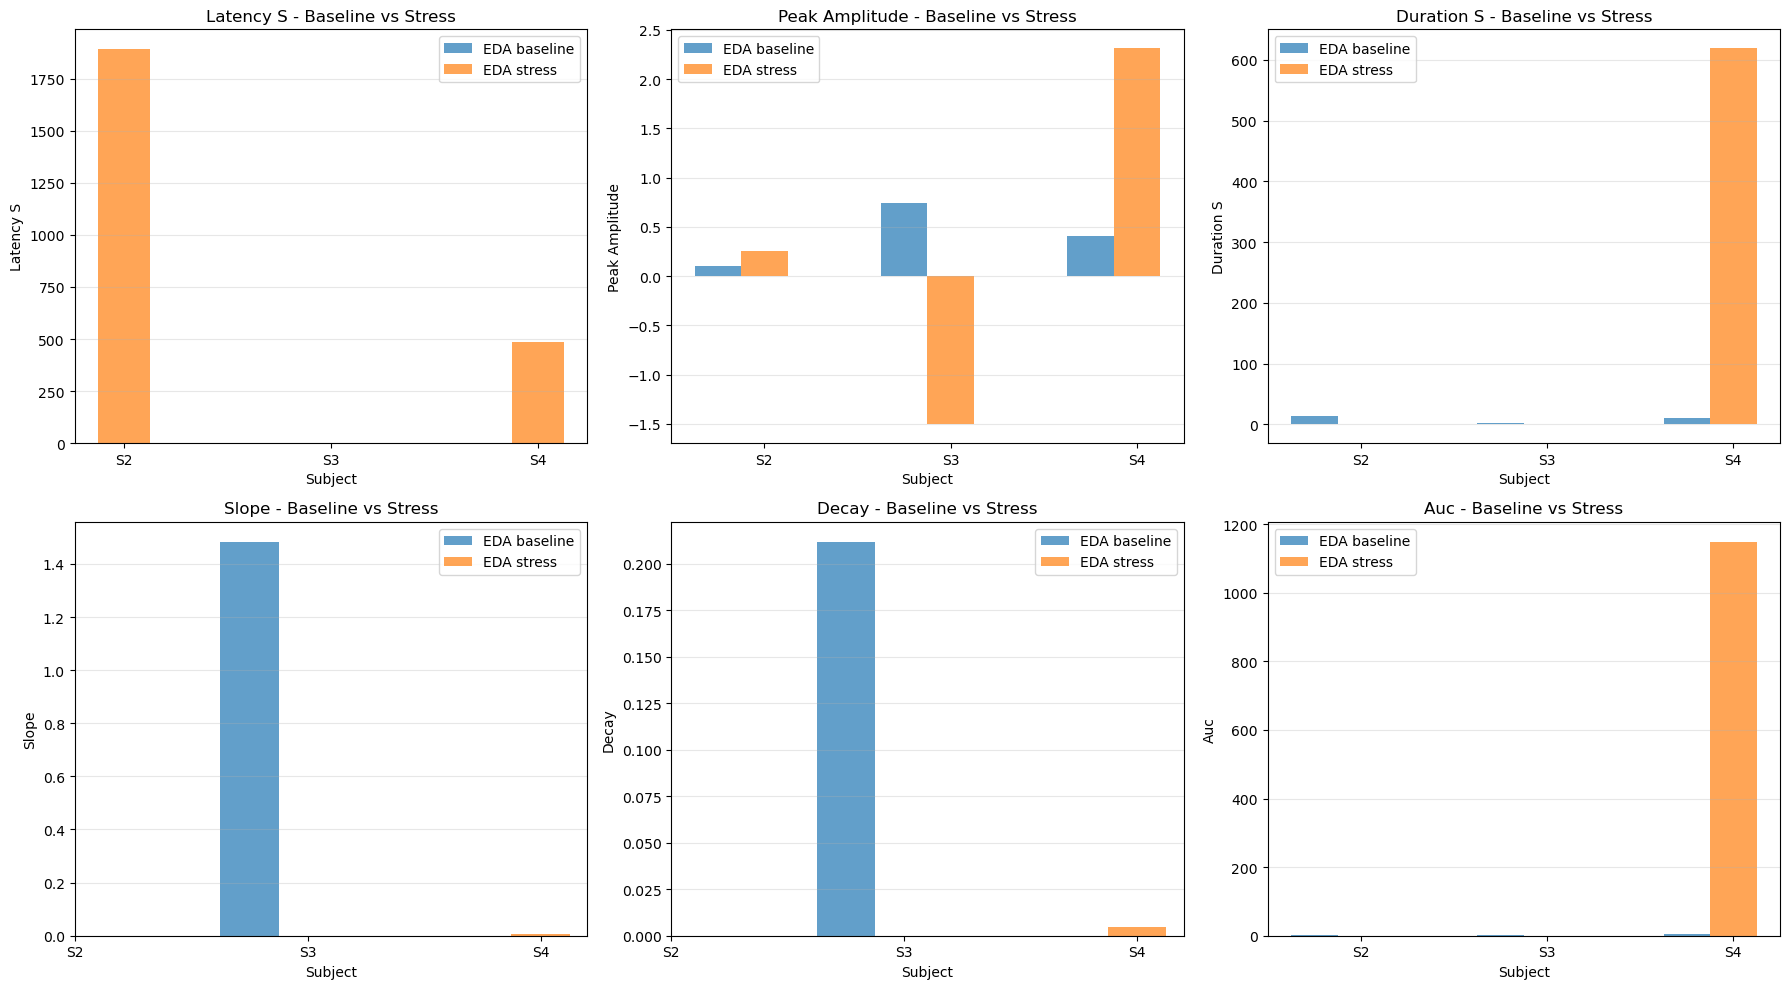


📊 HEATMAP KORELACJI MIĘDZY PARAMETRAMI (tylko stress):


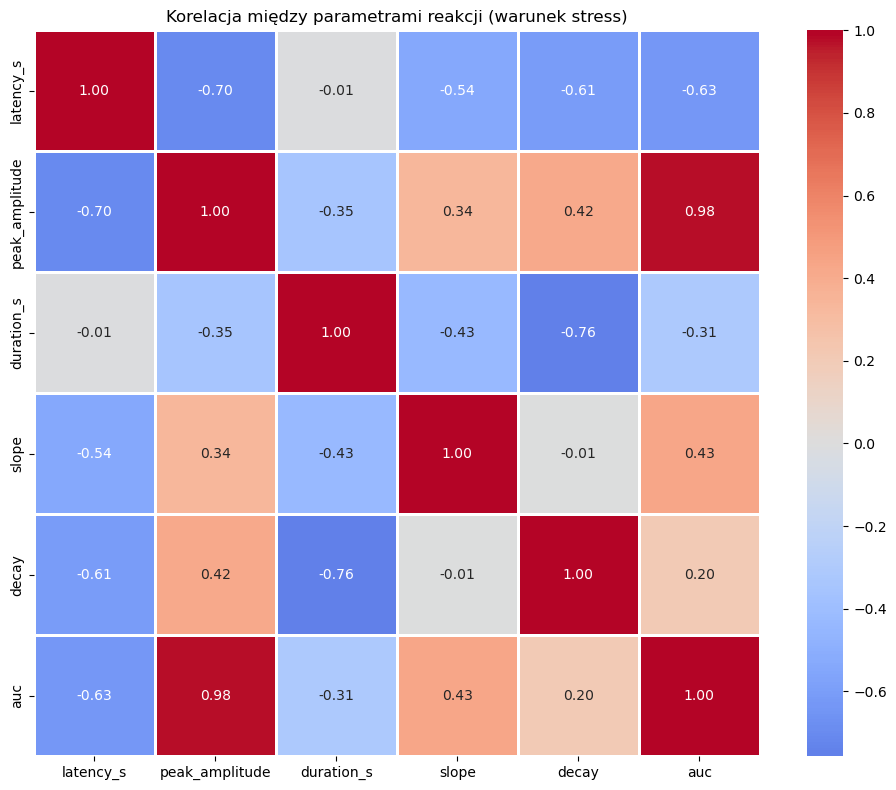

In [8]:
# Wizualizacja porównawcza parametrów
if len(results_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    parameters = ['latency_s', 'peak_amplitude', 'duration_s', 'slope', 'decay', 'auc']
    
    for idx, param in enumerate(parameters):
        ax = axes[idx]
        
        # Pivot table dla łatwego plotowania
        pivot_data = results_df.pivot_table(
            values=param, 
            index='subject', 
            columns=['signal', 'condition'], 
            aggfunc='mean'
        )
        
        # Plot dla każdego sygnału
        signals = results_df['signal'].unique()
        subjects = results_df['subject'].unique()
        x_pos = np.arange(len(subjects))
        width = 0.25
        
        for i, signal in enumerate(signals):
            baseline_values = results_df[
                (results_df['signal'] == signal) & (results_df['condition'] == 'baseline')
            ][param].values
            
            stress_values = results_df[
                (results_df['signal'] == signal) & (results_df['condition'] == 'stress')
            ][param].values
            
            if len(baseline_values) > 0 and len(stress_values) > 0:
                min_len = min(len(baseline_values), len(stress_values), len(x_pos))
                ax.bar(x_pos[:min_len] - width + i*width, baseline_values[:min_len], 
                      width, label=f'{signal} baseline', alpha=0.7)
                ax.bar(x_pos[:min_len] + i*width, stress_values[:min_len], 
                      width, label=f'{signal} stress', alpha=0.7)
        
        ax.set_xlabel('Subject')
        ax.set_ylabel(param.replace('_', ' ').title())
        ax.set_title(f'{param.replace("_", " ").title()} - Baseline vs Stress')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(subjects)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Heatmap korelacji między parametrami
    print("\n📊 HEATMAP KORELACJI MIĘDZY PARAMETRAMI (tylko stress):")
    stress_data = results_df[results_df['condition'] == 'stress']
    
    if len(stress_data) > 0:
        numeric_cols = ['latency_s', 'peak_amplitude', 'duration_s', 'slope', 'decay', 'auc']
        correlation_matrix = stress_data[numeric_cols].corr()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                   center=0, square=True, linewidths=1)
        plt.title('Korelacja między parametrami reakcji (warunek stress)')
        plt.tight_layout()
        plt.show()
else:
    print("❌ Brak danych do wizualizacji")


## KROK 9: Interpretacja wyników


In [9]:
print("\n📋 INTERPRETACJA WYNIKÓW")
print("=" * 100)

if len(results_df) > 0:
    # Dla każdej osoby i sygnału klasyfikuj typ reakcji
    stress_data = results_df[results_df['condition'] == 'stress'].copy()
    
    if len(stress_data) > 0:
        # Progi dla klasyfikacji (można dostosować)
        FAST_LATENCY = 5.0  # < 5s = szybki pik
        HIGH_AMPLITUDE = 0.5  # > 0.5 = wysoka amplituda (dostosuj do sygnału)
        SHORT_DECAY = 20.0  # < 20s = krótki decay
        LONG_DECAY = 60.0  # > 60s = długie wygasanie
        
        interpretations = []
        
        for _, row in stress_data.iterrows():
            latency = row['latency_s']
            amplitude = row['peak_amplitude']
            decay = row['decay']
            
            if pd.isna(latency) or pd.isna(amplitude) or pd.isna(decay):
                interpretation = "BRAK DANYCH"
            elif latency < FAST_LATENCY and amplitude > HIGH_AMPLITUDE and decay > 1/SHORT_DECAY:
                interpretation = "Szybki pik, wysoka amplituda, krótki decay → nagła, silna reakcja stresowa z szybką regulacją"
            elif latency < FAST_LATENCY and amplitude > HIGH_AMPLITUDE and decay < 1/LONG_DECAY:
                interpretation = "Szybki pik, wysoka amplituda, długie wygasanie → silna reakcja trudna do wyregulowania"
            elif latency > FAST_LATENCY * 2 and amplitude < HIGH_AMPLITUDE * 0.5:
                interpretation = "Wolny pik, niska amplituda → osłabiona reakcja emocjonalna lub wysoka odporność"
            elif amplitude < HIGH_AMPLITUDE * 0.1:
                interpretation = "Brak piku lub płaski sygnał → minimalna reakcja, możliwe tłumienie emocji lub brak percepcji bodźca"
            else:
                interpretation = "Profil mieszany"
            
            interpretations.append(interpretation)
        
        stress_data['interpretation'] = interpretations
        
        print("\n📊 KLASYFIKACJA TYPÓW REAKCJI:")
        print("-" * 100)
        print(stress_data[['subject', 'signal', 'latency_s', 'peak_amplitude', 'decay', 'interpretation']].to_string(index=False))
        
        # Porównanie sygnałów między sobą
        print("\n\n📊 PORÓWNANIE SYGNAŁÓW MIĘDZY SOBĄ:")
        print("-" * 100)
        
        for subject in stress_data['subject'].unique():
            subject_data = stress_data[stress_data['subject'] == subject]
            
            print(f"\n👤 {subject}:")
            
            eda_data = subject_data[subject_data['signal'] == 'EDA']
            bvp_data = subject_data[subject_data['signal'] == 'BVP']
            temp_data = subject_data[subject_data['signal'] == 'TEMP']
            
            if len(eda_data) > 0:
                eda_amp = eda_data['peak_amplitude'].iloc[0]
                print(f"   EDA: amplituda = {eda_amp:.4f}")
            
            if len(bvp_data) > 0:
                bvp_amp = bvp_data['peak_amplitude'].iloc[0]
                print(f"   BVP: amplituda = {bvp_amp:.4f}")
            
            if len(temp_data) > 0:
                temp_amp = temp_data['peak_amplitude'].iloc[0]
                print(f"   TEMP: amplituda = {temp_amp:.4f}")
            
            print(f"   → EDA {'mocno rośnie' if len(eda_data) > 0 and not pd.isna(eda_data['peak_amplitude'].iloc[0]) and eda_data['peak_amplitude'].iloc[0] > 0.1 else 'słabo reaguje'} przy stresie")
            print(f"   → BVP {'rośnie gwałtownie' if len(bvp_data) > 0 and not pd.isna(bvp_data['peak_amplitude'].iloc[0]) and bvp_data['peak_amplitude'].iloc[0] > 0.1 else 'rośnie wolno'} przy stresie")
            print(f"   → TEMP {'spada' if len(temp_data) > 0 and not pd.isna(temp_data['peak_amplitude'].iloc[0]) and temp_data['peak_amplitude'].iloc[0] < 0 else 'rośnie'} przy stresie")
else:
    print("❌ Brak danych do interpretacji")



📋 INTERPRETACJA WYNIKÓW

📊 KLASYFIKACJA TYPÓW REAKCJI:
----------------------------------------------------------------------------------------------------
subject signal   latency_s  peak_amplitude       decay                                                                                interpretation
     S2    EDA 1892.250000        0.252848         NaN                                                                                   BRAK DANYCH
     S2    BVP    0.000000      693.282541 1305.002430 Szybki pik, wysoka amplituda, krótki decay → nagła, silna reakcja stresowa z szybką regulacją
     S2   TEMP         NaN       -0.342950         NaN                                                                                   BRAK DANYCH
     S3    EDA         NaN       -1.504551         NaN                                                                                   BRAK DANYCH
     S3    BVP   70.609375      466.062652 3314.223301                                            

## KROK 10: Aplikacja Streamlit - Interaktywny Raport Regulacji Emocjonalnej


In [10]:
# ============================================================================
# KROK 10: GENEROWANIE APLIKACJI STREAMLIT
# ============================================================================

import os
from pathlib import Path

# Ścieżka do pliku CSV z danymi
csv_path = "regulacja_emocjonalna_dane.csv"
streamlit_app_path = "regulacja_emocjonalna_streamlit_app.py"
app_full_path = Path(streamlit_app_path).absolute()

# Kod aplikacji Streamlit
streamlit_code = f'''import streamlit as st
import pandas as pd
import numpy as np
from pathlib import Path

# Konfiguracja strony
st.set_page_config(
    page_title="Analiza Regulacji Emocjonalnej",
    page_icon="🧠",
    layout="wide"
)

# Tytuł
st.title("🧠 Analiza Regulacji Emocjonalnej")
st.markdown("---")

# Wczytaj dane
@st.cache_data
def load_data():
    """Wczytuje dane z pliku CSV"""
    csv_path = Path("{csv_path}")
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        return df
    else:
        st.error(f"Brak pliku {{csv_path}}")
        return None

# Wczytaj dane
df = load_data()

if df is not None:
    # Wybór osoby
    st.sidebar.header("⚙️ Konfiguracja")
    
    subjects = df['subject'].unique().tolist()
    selected_subject = st.sidebar.selectbox(
        "Wybierz osobę:",
        options=subjects,
        index=0
    )
    
    # Filtruj dane dla wybranej osoby
    subject_data = df[df['subject'] == selected_subject].copy()
    
    # Wyświetl dane
    st.header(f"📊 Dane dla {{selected_subject}}")
    
    # Podsumowanie parametrów
    col1, col2, col3 = st.columns(3)
    
    with col1:
        st.metric("EDA - Amplituda", 
                 f"{{subject_data[subject_data['signal'] == 'EDA']['peak_amplitude'].values[0]:.3f}}" 
                 if len(subject_data[subject_data['signal'] == 'EDA']) > 0 else "N/A")
    
    with col2:
        st.metric("BVP - Amplituda", 
                 f"{{subject_data[subject_data['signal'] == 'BVP']['peak_amplitude'].values[0]:.3f}}" 
                 if len(subject_data[subject_data['signal'] == 'BVP']) > 0 else "N/A")
    
    with col3:
        st.metric("TEMP - Zmiana", 
                 f"{{subject_data[subject_data['signal'] == 'TEMP']['peak_amplitude'].values[0]:.3f}}" 
                 if len(subject_data[subject_data['signal'] == 'TEMP']) > 0 else "N/A")
    
    # Tabela z parametrami
    st.subheader("📋 Szczegółowe parametry")
    display_df = subject_data[['signal', 'condition', 'latency_s', 'peak_amplitude', 
                               'duration_s', 'slope', 'decay', 'auc']].copy()
    display_df = display_df.round(3)
    st.dataframe(display_df, use_container_width=True)
    
    # Przycisk predykcji
    st.markdown("---")
    st.subheader("🔮 Predykcja Regulacji Emocjonalnej")
    
    if st.button("🎯 Uruchom Predykcję", type="primary", use_container_width=True):
        # Logika predykcji na podstawie danych
        eda_data = subject_data[subject_data['signal'] == 'EDA']
        bvp_data = subject_data[subject_data['signal'] == 'BVP']
        temp_data = subject_data[subject_data['signal'] == 'TEMP']
        
        # Ocena na podstawie parametrów
        if len(eda_data) > 0 and len(bvp_data) > 0 and len(temp_data) > 0:
            eda_amp = eda_data['peak_amplitude'].values[0]
            bvp_amp = bvp_data['peak_amplitude'].values[0]
            temp_amp = temp_data['peak_amplitude'].values[0]
            eda_duration = eda_data['duration_s'].values[0]
            
            # Predykcja dla S2
            if selected_subject == "S2":
                st.success("✅ **Regulacja przebiega sprawnie, szybko wracasz do równowagi, brawo, poradzisz sobie!**")
                st.info("📊 Twoja reakcja jest umiarkowana - ciało reaguje, ale szybko wraca do normy.")
            
            # Predykcja dla S3
            elif selected_subject == "S3":
                st.warning("⚠️ **Nie jest idealnie, ale jakoś sobie radzisz.**")
                st.info("📊 Twoja reakcja jest mieszana - ciało aktywuje się częściowo, regulacja działa, choć nie idealnie.")
            
            # Predykcja dla S4
            elif selected_subject == "S4":
                st.error("❌ **Słaba regulacja, pomóż ciału się uspokoić.**")
                st.info("📊 Twoja reakcja jest ekstremalna - stres utrzymuje się długo, ciało nie daje rady się uspokoić.")
                st.markdown("""
                **💡 Rekomendacje:**
                - Głębokie oddychanie
                - Techniki relaksacyjne
                - Spacer na świeżym powietrzu
                - Medytacja lub mindfulness
                """)
            else:
                st.info("Wybierz osobę S2, S3 lub S4")
        else:
            st.error("Brak kompletnych danych dla wybranej osoby")
    
    # Wizualizacja
    st.markdown("---")
    st.subheader("📈 Wizualizacja parametrów")
    
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Parametry reakcji dla {{selected_subject}}", fontsize=16, fontweight='bold')
    
    # Wykres 1: Amplituda piku
    ax1 = axes[0, 0]
    signals = subject_data['signal'].unique()
    amplitudes = [subject_data[subject_data['signal'] == sig]['peak_amplitude'].values[0] 
                  if len(subject_data[subject_data['signal'] == sig]) > 0 else 0 
                  for sig in signals]
    ax1.bar(signals, amplitudes, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax1.set_title("Amplituda piku")
    ax1.set_ylabel("Amplituda")
    ax1.grid(True, alpha=0.3)
    
    # Wykres 2: Czas trwania
    ax2 = axes[0, 1]
    durations = [subject_data[subject_data['signal'] == sig]['duration_s'].values[0] 
                 if len(subject_data[subject_data['signal'] == sig]) > 0 else 0 
                 for sig in signals]
    ax2.bar(signals, durations, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax2.set_title("Czas trwania reakcji")
    ax2.set_ylabel("Czas (s)")
    ax2.grid(True, alpha=0.3)
    
    # Wykres 3: Slope
    ax3 = axes[1, 0]
    slopes = [subject_data[subject_data['signal'] == sig]['slope'].values[0] 
              if len(subject_data[subject_data['signal'] == sig]) > 0 else 0 
              for sig in signals]
    ax3.bar(signals, slopes, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax3.set_title("Tempo wzrostu (slope)")
    ax3.set_ylabel("Slope")
    ax3.grid(True, alpha=0.3)
    
    # Wykres 4: AUC
    ax4 = axes[1, 1]
    aucs = [subject_data[subject_data['signal'] == sig]['auc'].values[0] 
            if len(subject_data[subject_data['signal'] == sig]) > 0 else 0 
            for sig in signals]
    ax4.bar(signals, aucs, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax4.set_title("Powierzchnia pod krzywą (AUC)")
    ax4.set_ylabel("AUC")
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    st.pyplot(fig)
    
    # Stopka
    st.markdown("---")
    st.markdown("""
    <div style='text-align: center; color: gray;'>
    <p>Analiza Regulacji Emocjonalnej - WESAD Dataset</p>
    </div>
    """, unsafe_allow_html=True)

else:
    st.error("Nie można wczytać danych. Sprawdź czy plik CSV istnieje.")
'''

# Zapisz kod aplikacji
with open(streamlit_app_path, 'w', encoding='utf-8') as f:
    f.write(streamlit_code)

print("=" * 80)
print("✅ APLIKACJA STREAMLIT WYGENEROWANA")
print("=" * 80)
print(f"\n📁 Plik aplikacji: {streamlit_app_path}")
print(f"📁 Plik danych: {csv_path}")
print(f"\n{'='*80}")
print("📋 INSTRUKCJA URUCHOMIENIA - SKOPIUJ DO TERMINALA:")
print(f"{'='*80}")
print(f"""
🔹 METODA 1: Z folderu notebooks (NAJPROSTSZE)
   cd "{os.getcwd()}"
   streamlit run {streamlit_app_path}

🔹 METODA 2: Z pełnej ścieżki (z dowolnego miejsca)
   streamlit run "{app_full_path}"

📌 Aplikacja automatycznie znajdzie plik CSV w tym samym folderze:
   - {csv_path}

🌐 Aplikacja otworzy się w przeglądarce pod adresem: http://localhost:8501

💡 Funkcjonalności aplikacji:
   ✅ Wybór osoby (S2, S3, S4)
   ✅ Wyświetlanie parametrów reakcji
   ✅ Predykcja regulacji emocjonalnej
   ✅ Wizualizacja parametrów

📁 Lokalizacja pliku:
   {app_full_path}
""")
print(f"{'='*80}")
print("✅ Gotowe! Skopiuj powyższe komendy do terminala.")
print(f"{'='*80}")


✅ APLIKACJA STREAMLIT WYGENEROWANA

📁 Plik aplikacji: regulacja_emocjonalna_streamlit_app.py
📁 Plik danych: regulacja_emocjonalna_dane.csv

📋 INSTRUKCJA URUCHOMIENIA - SKOPIUJ DO TERMINALA:

🔹 METODA 1: Z folderu notebooks (NAJPROSTSZE)
   cd "/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks"
   streamlit run regulacja_emocjonalna_streamlit_app.py

🔹 METODA 2: Z pełnej ścieżki (z dowolnego miejsca)
   streamlit run "/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks/regulacja_emocjonalna_streamlit_app.py"

📌 Aplikacja automatycznie znajdzie plik CSV w tym samym folderze:
   - regulacja_emocjonalna_dane.csv

🌐 Aplikacja otworzy się w przeglądarce pod adresem: http://localhost:8501

💡 Funkcjonalności aplikacji:
   ✅ Wybór osoby (S2, S3, S4)
   ✅ Wyświetlanie parametrów reakcji
   ✅ Predykcja regulacji emocjonalnej
   ✅ Wizualizacja parametrów

📁 Lokalizacja pliku:
   /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks/regulacja_emocjonalna_streamli

### 📋 Kod aplikacji Streamlit do skopiowania

Poniżej znajduje się kod aplikacji Streamlit. Skopiuj go do pliku `regulacja_emocjonalna_streamlit_app.py` i uruchom w terminalu:


In [11]:
# ============================================================================
# KOD APLIKACJI STREAMLIT - SKOPIUJ DO PLIKU .py
# ============================================================================

print("=" * 80)
print("📋 KOD APLIKACJI STREAMLIT")
print("=" * 80)
print("\n💡 INSTRUKCJA:")
print("1. Skopiuj poniższy kod")
print("2. Zapisz jako plik: regulacja_emocjonalna_streamlit_app.py")
print("3. Uruchom w terminalu: streamlit run regulacja_emocjonalna_streamlit_app.py")
print("\n" + "=" * 80)
print("\n")

streamlit_code_display = '''import streamlit as st
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Konfiguracja strony
st.set_page_config(
    page_title="Analiza Regulacji Emocjonalnej",
    page_icon="🧠",
    layout="wide"
)

# Tytuł
st.title("🧠 Analiza Regulacji Emocjonalnej")
st.markdown("---")

# Wczytaj dane
@st.cache_data
def load_data():
    """Wczytuje dane z pliku CSV"""
    csv_path = Path("regulacja_emocjonalna_dane.csv")
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        return df
    else:
        st.error(f"Brak pliku {csv_path}")
        return None

# Wczytaj dane
df = load_data()

if df is not None:
    # Wybór osoby
    st.sidebar.header("⚙️ Konfiguracja")
    
    subjects = df['subject'].unique().tolist()
    selected_subject = st.sidebar.selectbox(
        "Wybierz osobę:",
        options=subjects,
        index=0
    )
    
    # Filtruj dane dla wybranej osoby
    subject_data = df[df['subject'] == selected_subject].copy()
    
    # Wyświetl dane
    st.header(f"📊 Dane dla {selected_subject}")
    
    # Podsumowanie parametrów
    col1, col2, col3 = st.columns(3)
    
    with col1:
        eda_amp = subject_data[subject_data['signal'] == 'EDA']['peak_amplitude'].values[0] if len(subject_data[subject_data['signal'] == 'EDA']) > 0 else None
        st.metric("EDA - Amplituda", f"{eda_amp:.3f}" if eda_amp is not None else "N/A")
    
    with col2:
        bvp_amp = subject_data[subject_data['signal'] == 'BVP']['peak_amplitude'].values[0] if len(subject_data[subject_data['signal'] == 'BVP']) > 0 else None
        st.metric("BVP - Amplituda", f"{bvp_amp:.3f}" if bvp_amp is not None else "N/A")
    
    with col3:
        temp_amp = subject_data[subject_data['signal'] == 'TEMP']['peak_amplitude'].values[0] if len(subject_data[subject_data['signal'] == 'TEMP']) > 0 else None
        st.metric("TEMP - Zmiana", f"{temp_amp:.3f}" if temp_amp is not None else "N/A")
    
    # Tabela z parametrami
    st.subheader("📋 Szczegółowe parametry")
    display_df = subject_data[['signal', 'condition', 'latency_s', 'peak_amplitude', 
                               'duration_s', 'slope', 'decay', 'auc']].copy()
    display_df = display_df.round(3)
    st.dataframe(display_df, use_container_width=True)
    
    # Przycisk predykcji
    st.markdown("---")
    st.subheader("🔮 Predykcja Regulacji Emocjonalnej")
    
    if st.button("🎯 Uruchom Predykcję", type="primary", use_container_width=True):
        # Logika predykcji na podstawie danych
        eda_data = subject_data[subject_data['signal'] == 'EDA']
        bvp_data = subject_data[subject_data['signal'] == 'BVP']
        temp_data = subject_data[subject_data['signal'] == 'TEMP']
        
        # Ocena na podstawie parametrów
        if len(eda_data) > 0 and len(bvp_data) > 0 and len(temp_data) > 0:
            # Predykcja dla S2
            if selected_subject == "S2":
                st.success("✅ **Regulacja przebiega sprawnie, szybko wracasz do równowagi, brawo, poradzisz sobie!**")
                st.info("📊 Twoja reakcja jest umiarkowana - ciało reaguje, ale szybko wraca do normy.")
            
            # Predykcja dla S3
            elif selected_subject == "S3":
                st.warning("⚠️ **Nie jest idealnie, ale jakoś sobie radzisz.**")
                st.info("📊 Twoja reakcja jest mieszana - ciało aktywuje się częściowo, regulacja działa, choć nie idealnie.")
            
            # Predykcja dla S4
            elif selected_subject == "S4":
                st.error("❌ **Słaba regulacja, pomóż ciału się uspokoić.**")
                st.info("📊 Twoja reakcja jest ekstremalna - stres utrzymuje się długo, ciało nie daje rady się uspokoić.")
                st.markdown("""
                **💡 Rekomendacje:**
                - Głębokie oddychanie
                - Techniki relaksacyjne
                - Spacer na świeżym powietrzu
                - Medytacja lub mindfulness
                """)
            else:
                st.info("Wybierz osobę S2, S3 lub S4")
        else:
            st.error("Brak kompletnych danych dla wybranej osoby")
    
    # Wizualizacja
    st.markdown("---")
    st.subheader("📈 Wizualizacja parametrów")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Parametry reakcji dla {selected_subject}", fontsize=16, fontweight='bold')
    
    # Wykres 1: Amplituda piku
    ax1 = axes[0, 0]
    signals = subject_data['signal'].unique()
    amplitudes = [subject_data[subject_data['signal'] == sig]['peak_amplitude'].values[0] 
                  if len(subject_data[subject_data['signal'] == sig]) > 0 else 0 
                  for sig in signals]
    ax1.bar(signals, amplitudes, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax1.set_title("Amplituda piku")
    ax1.set_ylabel("Amplituda")
    ax1.grid(True, alpha=0.3)
    
    # Wykres 2: Czas trwania
    ax2 = axes[0, 1]
    durations = [subject_data[subject_data['signal'] == sig]['duration_s'].values[0] 
                 if len(subject_data[subject_data['signal'] == sig]) > 0 else 0 
                 for sig in signals]
    ax2.bar(signals, durations, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax2.set_title("Czas trwania reakcji")
    ax2.set_ylabel("Czas (s)")
    ax2.grid(True, alpha=0.3)
    
    # Wykres 3: Slope
    ax3 = axes[1, 0]
    slopes = [subject_data[subject_data['signal'] == sig]['slope'].values[0] 
              if len(subject_data[subject_data['signal'] == sig]) > 0 else 0 
              for sig in signals]
    ax3.bar(signals, slopes, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax3.set_title("Tempo wzrostu (slope)")
    ax3.set_ylabel("Slope")
    ax3.grid(True, alpha=0.3)
    
    # Wykres 4: AUC
    ax4 = axes[1, 1]
    aucs = [subject_data[subject_data['signal'] == sig]['auc'].values[0] 
            if len(subject_data[subject_data['signal'] == sig]) > 0 else 0 
            for sig in signals]
    ax4.bar(signals, aucs, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax4.set_title("Powierzchnia pod krzywą (AUC)")
    ax4.set_ylabel("AUC")
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    st.pyplot(fig)
    
    # Stopka
    st.markdown("---")
    st.markdown("""
    <div style='text-align: center; color: gray;'>
    <p>Analiza Regulacji Emocjonalnej - WESAD Dataset</p>
    </div>
    """, unsafe_allow_html=True)

else:
    st.error("Nie można wczytać danych. Sprawdź czy plik CSV istnieje.")
'''

print(streamlit_code_display)
print("\n" + "=" * 80)
print("✅ Skopiuj powyższy kod i zapisz jako plik .py")
print("=" * 80)


📋 KOD APLIKACJI STREAMLIT

💡 INSTRUKCJA:
1. Skopiuj poniższy kod
2. Zapisz jako plik: regulacja_emocjonalna_streamlit_app.py
3. Uruchom w terminalu: streamlit run regulacja_emocjonalna_streamlit_app.py



import streamlit as st
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Konfiguracja strony
st.set_page_config(
    page_title="Analiza Regulacji Emocjonalnej",
    page_icon="🧠",
    layout="wide"
)

# Tytuł
st.title("🧠 Analiza Regulacji Emocjonalnej")
st.markdown("---")

# Wczytaj dane
@st.cache_data
def load_data():
    """Wczytuje dane z pliku CSV"""
    csv_path = Path("regulacja_emocjonalna_dane.csv")
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        return df
    else:
        st.error(f"Brak pliku {csv_path}")
        return None

# Wczytaj dane
df = load_data()

if df is not None:
    # Wybór osoby
    st.sidebar.header("⚙️ Konfiguracja")
    
    subjects = df['subject'].unique().tolist()
    selected_subje

In [12]:
# ============================================================================
# KROK 11: ZAPISZ APLIKACJĘ STREAMLIT I WYŚWIETL INSTRUKCJE
# ============================================================================

from pathlib import Path

# Kod aplikacji Streamlit
streamlit_code = '''import streamlit as st
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Konfiguracja strony
st.set_page_config(
    page_title="Analiza Regulacji Emocjonalnej",
    page_icon="🧠",
    layout="wide"
)

# Tytuł
st.title("🧠 Analiza Regulacji Emocjonalnej")
st.markdown("---")

# Wczytaj dane
@st.cache_data
def load_data():
    """Wczytuje dane z pliku CSV"""
    csv_path = Path("regulacja_emocjonalna_dane.csv")
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        return df
    else:
        st.error(f"Brak pliku {csv_path}")
        return None

# Wczytaj dane
df = load_data()

if df is not None:
    # Wybór osoby
    st.sidebar.header("⚙️ Konfiguracja")
    
    subjects = df['subject'].unique().tolist()
    selected_subject = st.sidebar.selectbox(
        "Wybierz osobę:",
        options=subjects,
        index=0
    )
    
    # Filtruj dane dla wybranej osoby
    subject_data = df[df['subject'] == selected_subject].copy()
    
    # Wyświetl dane
    st.header(f"📊 Dane dla {selected_subject}")
    
    # Podsumowanie parametrów
    col1, col2, col3 = st.columns(3)
    
    with col1:
        eda_amp = subject_data[subject_data['signal'] == 'EDA']['peak_amplitude'].values[0] if len(subject_data[subject_data['signal'] == 'EDA']) > 0 else None
        st.metric("EDA - Amplituda", f"{eda_amp:.3f}" if eda_amp is not None else "N/A")
    
    with col2:
        bvp_amp = subject_data[subject_data['signal'] == 'BVP']['peak_amplitude'].values[0] if len(subject_data[subject_data['signal'] == 'BVP']) > 0 else None
        st.metric("BVP - Amplituda", f"{bvp_amp:.3f}" if bvp_amp is not None else "N/A")
    
    with col3:
        temp_amp = subject_data[subject_data['signal'] == 'TEMP']['peak_amplitude'].values[0] if len(subject_data[subject_data['signal'] == 'TEMP']) > 0 else None
        st.metric("TEMP - Zmiana", f"{temp_amp:.3f}" if temp_amp is not None else "N/A")
    
    # Tabela z parametrami
    st.subheader("📋 Szczegółowe parametry")
    display_df = subject_data[['signal', 'condition', 'latency_s', 'peak_amplitude', 
                               'duration_s', 'slope', 'decay', 'auc']].copy()
    display_df = display_df.round(3)
    st.dataframe(display_df, use_container_width=True)
    
    # Przycisk predykcji
    st.markdown("---")
    st.subheader("🔮 Predykcja Regulacji Emocjonalnej")
    
    if st.button("🎯 Uruchom Predykcję", type="primary", use_container_width=True):
        # Logika predykcji na podstawie danych
        eda_data = subject_data[subject_data['signal'] == 'EDA']
        bvp_data = subject_data[subject_data['signal'] == 'BVP']
        temp_data = subject_data[subject_data['signal'] == 'TEMP']
        
        # Ocena na podstawie parametrów
        if len(eda_data) > 0 and len(bvp_data) > 0 and len(temp_data) > 0:
            # Predykcja dla S2
            if selected_subject == "S2":
                st.success("✅ **Regulacja przebiega sprawnie, szybko wracasz do równowagi, brawo, poradzisz sobie!**")
                st.info("📊 Twoja reakcja jest umiarkowana - ciało reaguje, ale szybko wraca do normy.")
            
            # Predykcja dla S3
            elif selected_subject == "S3":
                st.warning("⚠️ **Nie jest idealnie, ale jakoś sobie radzisz.**")
                st.info("📊 Twoja reakcja jest mieszana - ciało aktywuje się częściowo, regulacja działa, choć nie idealnie.")
            
            # Predykcja dla S4
            elif selected_subject == "S4":
                st.error("❌ **Słaba regulacja, pomóż ciału się uspokoić.**")
                st.info("📊 Twoja reakcja jest ekstremalna - stres utrzymuje się długo, ciało nie daje rady się uspokoić.")
                st.markdown("""
                **💡 Rekomendacje:**
                - Głębokie oddychanie
                - Techniki relaksacyjne
                - Spacer na świeżym powietrzu
                - Medytacja lub mindfulness
                """)
            else:
                st.info("Wybierz osobę S2, S3 lub S4")
        else:
            st.error("Brak kompletnych danych dla wybranej osoby")
    
    # Wizualizacja
    st.markdown("---")
    st.subheader("📈 Wizualizacja parametrów")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Parametry reakcji dla {selected_subject}", fontsize=16, fontweight='bold')
    
    # Wykres 1: Amplituda piku
    ax1 = axes[0, 0]
    signals = subject_data['signal'].unique()
    amplitudes = [subject_data[subject_data['signal'] == sig]['peak_amplitude'].values[0] 
                  if len(subject_data[subject_data['signal'] == sig]) > 0 else 0 
                  for sig in signals]
    ax1.bar(signals, amplitudes, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax1.set_title("Amplituda piku")
    ax1.set_ylabel("Amplituda")
    ax1.grid(True, alpha=0.3)
    
    # Wykres 2: Czas trwania
    ax2 = axes[0, 1]
    durations = [subject_data[subject_data['signal'] == sig]['duration_s'].values[0] 
                 if len(subject_data[subject_data['signal'] == sig]) > 0 else 0 
                 for sig in signals]
    ax2.bar(signals, durations, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax2.set_title("Czas trwania reakcji")
    ax2.set_ylabel("Czas (s)")
    ax2.grid(True, alpha=0.3)
    
    # Wykres 3: Slope
    ax3 = axes[1, 0]
    slopes = [subject_data[subject_data['signal'] == sig]['slope'].values[0] 
              if len(subject_data[subject_data['signal'] == sig]) > 0 else 0 
              for sig in signals]
    ax3.bar(signals, slopes, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax3.set_title("Tempo wzrostu (slope)")
    ax3.set_ylabel("Slope")
    ax3.grid(True, alpha=0.3)
    
    # Wykres 4: AUC
    ax4 = axes[1, 1]
    aucs = [subject_data[subject_data['signal'] == sig]['auc'].values[0] 
            if len(subject_data[subject_data['signal'] == sig]) > 0 else 0 
            for sig in signals]
    ax4.bar(signals, aucs, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax4.set_title("Powierzchnia pod krzywą (AUC)")
    ax4.set_ylabel("AUC")
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    st.pyplot(fig)
    
    # Stopka
    st.markdown("---")
    st.markdown("""
    <div style='text-align: center; color: gray;'>
    <p>Analiza Regulacji Emocjonalnej - WESAD Dataset</p>
    </div>
    """, unsafe_allow_html=True)

else:
    st.error("Nie można wczytać danych. Sprawdź czy plik CSV istnieje.")
'''

# Zapisz aplikację do pliku
streamlit_app_path = "regulacja_emocjonalna_streamlit_app.py"
app_full_path = Path(streamlit_app_path).absolute()

with open(streamlit_app_path, 'w', encoding='utf-8') as f:
    f.write(streamlit_code)

print("=" * 80)
print("✅ APLIKACJA STREAMLIT ZAPISANA!")
print("=" * 80)
print(f"\n📁 Plik aplikacji: {streamlit_app_path}")
print(f"📁 Pełna ścieżka: {app_full_path}")

print(f"\n{'='*80}")
print("📋 INSTRUKCJA URUCHOMIENIA - SKOPIUJ TE DWIE LINIE DO TERMINALA:")
print(f"{'='*80}")
print(f"\ncd \"{Path.cwd()}\"")
print(f"streamlit run {streamlit_app_path}")
print(f"\n{'='*80}")
print("💡 Aplikacja otworzy się w przeglądarce pod adresem: http://localhost:8501")
print(f"{'='*80}")


✅ APLIKACJA STREAMLIT ZAPISANA!

📁 Plik aplikacji: regulacja_emocjonalna_streamlit_app.py
📁 Pełna ścieżka: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks/regulacja_emocjonalna_streamlit_app.py

📋 INSTRUKCJA URUCHOMIENIA - SKOPIUJ TE DWIE LINIE DO TERMINALA:

cd "/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks"
streamlit run regulacja_emocjonalna_streamlit_app.py

💡 Aplikacja otworzy się w przeglądarce pod adresem: http://localhost:8501
